In [1]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 16
IMAGE_SHAPE = (128, 128)
PROCESSED_DATASET_PATH_MNETV1_TRAIN = Path("/kaggle/input/dataset/dataset/train/")
PROCESSED_DATASET_PATH_MNETV1_TEST = Path("/kaggle/input/dataset/dataset/test/")
PROCESSED_DATASET_PATH_MNETV1_VAL = Path("/kaggle/input/dataset/dataset/val/")

# PRETRAINED_MODEL = "/kaggle/input/animal-faces-model/_e30.pth"

print(device)

cuda:0


In [2]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_TRAIN, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

val_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)

12903 1611 1611 ['cat', 'dog', 'wild']


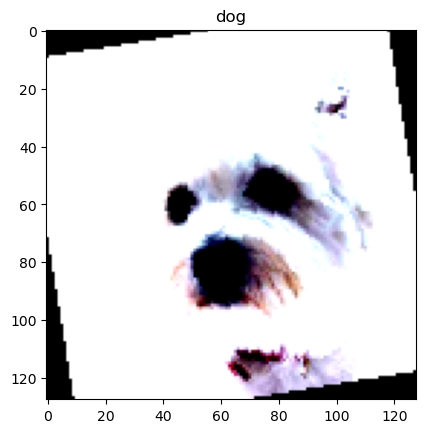

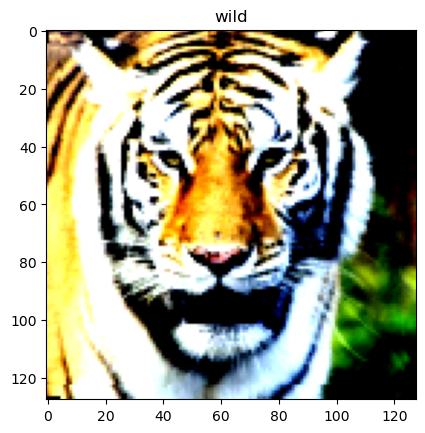

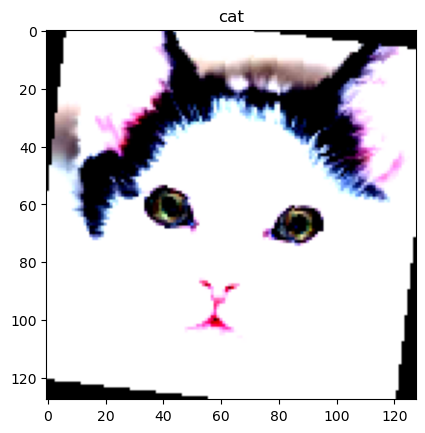

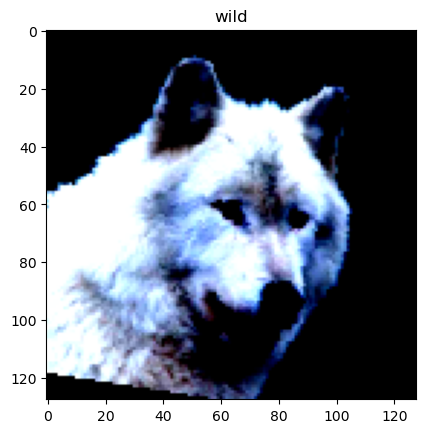

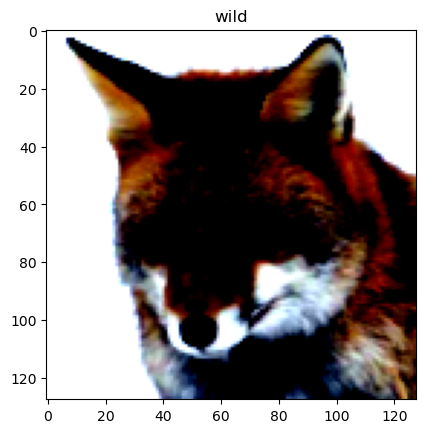

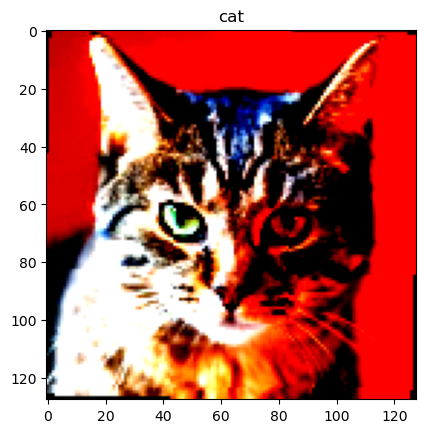

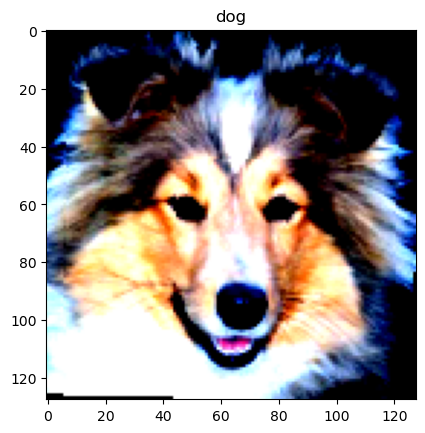

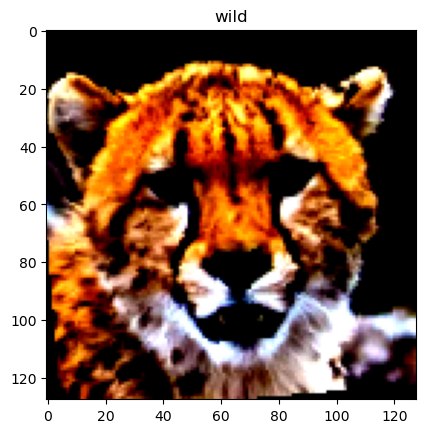

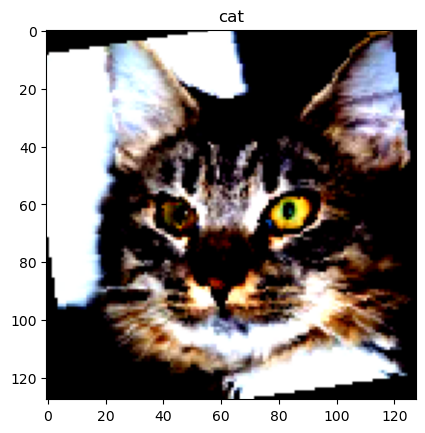

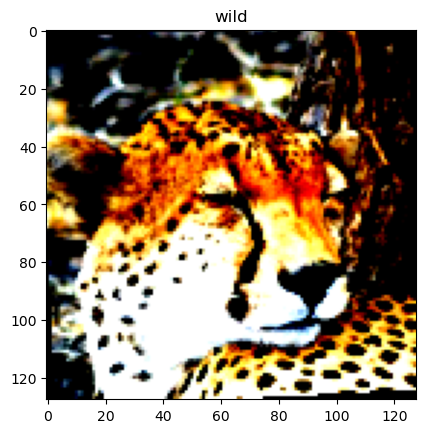

3


In [3]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(10):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()
print(len(train_set.classes))

In [4]:
model = torchvision.models.resnet18(num_classes=len(train_set.classes), weights=None)
model = model.to(device)
# model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [6]:
import os
os.makedirs("/kaggle/working/mods")

In [7]:
open("/kaggle/working/logs.csv", "a", newline="")
log_file = open("/kaggle/working/logs.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    try:
        if mode == 'train':
            model.train()
        elif mode == 'val':
            model.eval()

        loss = correct = 0
        for feature, target in tqdm(dataloader, desc=mode.title()):
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            loss = criterion(output, target)

            if mode == 'train':
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            loss += loss.item() * feature.shape[0]
            correct += (output.argmax(1) == target).sum().item()
        loss = loss/len(dataset)
        accuracy = correct/len(dataset)
        return loss, accuracy
    except:
        pass

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    try:
        train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer)
        with torch.no_grad():
            test_cost, test_score = loop_fn('val', val_set, val_loader, model, criterion, optimizer)
        print(epoch, float(train_cost), train_score, float(test_cost), test_score)
        csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
    except:
        pass
torch.save(model.state_dict(), f"/kaggle/working/mods/_e{epoch}.pth")

Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

1 0.0005977050168439746 0.692862125087189 0.0030328871216624975 0.8261949099937926


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

2 0.0004016414168290794 0.8846004805084089 0.00043398389243520796 0.9124767225325885


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x716cf22e3b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/101 [00:00<?, ?it/s]

3 4.915716272080317e-05 0.9221886383011703 0.0005163852474652231 0.9528243327126009


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x716cf22e3b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    AssertionErrorassert self._parent_pid == os.getpid(), 'can only test a child process'
: 

Train:   0%|          | 0/807 [00:00<?, ?it/s]

can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x716cf22e3b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/101 [00:00<?, ?it/s]

4 2.874807478292496e-06 0.9407114624505929 0.0004514892934821546 0.9621353196772191


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x716cf22e3b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x716cf22e3b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Val:   0%|          | 0/101 [00:00<?, ?it/s]

5 2.1559033029916463e-06 0.9523366658916531 0.0005304032820276916 0.9683426443202979


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x716cf22e3b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x716cf22e3b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Val:   0%|          | 0/101 [00:00<?, ?it/s]

6 1.0569925734671415e-06 0.9593117879562892 0.00012953061377629638 0.9689633767846059


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x716cf22e3b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x716cf22e3b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Train:   0%|          | 0/807 [00:00<?, ?it/s]

: can only test a child process


Val:   0%|          | 0/101 [00:00<?, ?it/s]

7 0.0004249442426953465 0.9671394249399364 0.00016668546595610678 0.9720670391061452


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

8 3.083555668581539e-07 0.9708594900410757 1.6470577975269407e-05 0.9745499689633768


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

9 7.260521215357585e-06 0.9735720375106565 9.283247059954647e-09 0.9658597144630664


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

10 1.5976695067365654e-05 0.9810896690692087 6.05694140176638e-06 0.9757914338919925


In [8]:
y_pred = []
y_true = []

test_loader2 = DataLoader(test_set, shuffle=True)
for images, labels in test_loader2:
        output = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
        y_pred.extend([output])
        
        labels = labels.data.cpu().numpy()
        y_true.extend([labels])

from sklearn.metrics import accuracy_score, classification_report


print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")
print(classification_report(y_true, y_pred,target_names=train_set.classes))

Overall Accuracy:  97.58  %
              precision    recall  f1-score   support

         cat       0.98      0.99      0.98       565
         dog       0.98      0.96      0.97       523
        wild       0.97      0.98      0.97       523

    accuracy                           0.98      1611
   macro avg       0.98      0.98      0.98      1611
weighted avg       0.98      0.98      0.98      1611

